# Spotify Streaming Music Service 

## Customer Churn Prediction with Machine Learning


## Project Overview

Sparkify is a simulated music streaming service emulating a streaming service such as Spotify. Sparkify users stream music using the free subscription plan with ads or paid subscription plan without ads. 

Users may engage in actions such as thumb up or down, add songs to playlists, add friends, etc. Users are free to change their subscription plan by upgrading from free to paid, by downgrading from paid to free, or to entirely stop using the service by cancelling the subscription.

Any user interaction with the service triggers a certain log event that represents our data. A log contains information about the event time, identifies the session and the user, includes some of user attributes, subscription plan, user interaction type etc.

There are three datasets with event log information available for our project:

* full (big) dataset of 12GB available on Amazon EMR cluster,
* medium dataset available on IBM Watson cluster,
* mini (sample) dataset available on local machine.

This project will make use of the mini dataset available for use on a local machine.

## Problem Statement

**Customer churn is simply the rate at which customers cancel their subscriptions.**

The goal of a customer churn model is to evaluate the behaviors and attributes of current and former customers to determine trends that lead to churn. Several behavioral factors that are widely used in these models are customer purchase intervals, cancellations, follow-up calls, emails, and on-page engagement. Customer attributes, like demographics, location, and income, can also be indicators of churn likelihood.

Customer churn models are generally created with a classification algorithm, like logistic regression or decision trees. For these algorithms, all categorical data must be converted into a numerical equivalent using techniques like one-hot-encoding.

Businesses strive to identify the potential users who are likely to leave before they actually leave the service in order to take actions to retain them. Some estimate that it may costs five or six times as much to acquire a new customer than it does to retain the ones you have.

Our churned users are defined as those who cancel their Spotify subscription. 

The identification of potential churned users is a binary classification problem: either a user is churned or non-churned. In order to be able to properly classify users we will perform exploratory data analysis against sample data, then we’ll engineer the features that we will find important for churn classification, and finally, we’ll exercise modelling with selected features using various learning methods.

The solution of our problem is to create a machine learning model that can provide prediction results achieving the project goal according to the chosen metrics as described in the next section.



## Model Evaluation Metrics

Choosing correct metrics is important for the success of machine learning model evaluation. Our full dataset has 22,278 users out of which 5,003 are cancelled users (22.46%). If we use accuracy to measure the prediction quality of our model and our model identifies every users as a non-churned we achieve accuracy of 77.54% which is pretty high value for a blind model that always predicts 0.

We will use the precision-recall metrics instead. The precision tells us the proportion how many churned users we successfully identified among all users that we identified as churned while the recall tells us the proportion how many churned users we successfully identified among all churned users:

**Precision**  What proportion of positive identifications was actually correct?

Precision = True Positives / (True Positives + False Positives )


**Recall**  What proportion of actual positives was identified correctly?

Recall = True Positives / ( True Positives + False Negatives )

TP are true positives or correctly identified churned users, FP are false positives or non-churned users incorrectly identified as churned users, and FN are false negatives or churned users incorrectly identified as non-churned users.

Normally, the classes are not perfectly distributed. Not in all cases we can clearly separate all points of a possitive class from all points of a negative class, so there will always be a certain grey zone where classes are mixed together. The inevitable consequence is an inverse relationship between the precision and recall: by increasing one parameter (precision or recall) the other parameter decreases (recall or precision). This is known as precision-recall tradeoff.

Due to a high level of abstraction in this study we cannot focus on a specific business situation regareing precision-recall tradeoff. The F1 score is used in this project as the evaluation metric. The F1 score is defined as

F1 = (2 * precision * recall) / (precision + recall)

which is a balanced score between precision and recall. When predicting a churn, precision aims to make sure that it is really a churn, whereas recall aims to not miss any real churns. Therefore, I choose F1 score as the metric to evaluate model performance.


## I. Import libraries and Spark Session


In [1]:
# import libraries
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#! pip install pyspark
import pyspark
from pyspark import SparkContext, SparkConf

from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when, desc, asc, countDistinct, when, isnan
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround
from pyspark.sql.types import IntegerType, FloatType, DateType, TimestampType, StringType

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVC, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

# import libraries
from pyspark.sql import SparkSession, Window
from pyspark import SparkFiles
from pyspark.sql.functions import avg, col, concat, count, desc, \
asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, log, sqrt, cbrt, exp
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType

%matplotlib inline


In [2]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()


22/12/04 13:21:51 WARN Utils: Your hostname, Andrews-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.39 instead (on interface en0)
22/12/04 13:21:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/04 13:21:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/04 13:21:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/12/04 13:21:53 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Load & Clean Sparkify Dataset
* mini-dataset file: mini_sparkify_event_data.json

In [3]:
# load data
path = "data/mini_sparkify_event_data.json"
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = spark.read.json(path)
df.createOrReplaceTempView("df")


In [4]:
# print schema
df.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# load data
path = "data/mini_sparkify_event_data.json"
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
sparkify_events = spark.read.json(path)
sparkify_events.createOrReplaceTempView("sparkify_events")


In [6]:
# print schema
sparkify_events.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn
Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the Downgrade events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Examine Elements of Dataframe


In [7]:
# show first rows
df.select('artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', \
          'length', 'level', 'location', 'method').show(5)


+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|
|    Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|     Bakersfield, CA|   PUT|
|          Enigma|Logged In|    Micah|     M|           80|    Long|262.71302| free|Boston-Cambridge-...|   PUT|
|       Daft Punk|Logged In|    Colin|     M|           52| Freeman|223.60771| paid|     Bakersfield, CA|   PUT|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------

In [8]:
# show first rows
df.select('page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', \
          'userId').show(5)


+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|NextSong|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|     9|
|NextSong|1538173362000|       29|   Time For Miracles|   200|1538352394000|Mozilla/5.0 (Wind...|    30|
|NextSong|1538331630000|        8|Knocking On Forbi...|   200|1538352416000|"Mozilla/5.0 (Win...|     9|
|NextSong|1538173362000|       29|Harder Better Fas...|   200|1538352676000|Mozilla/5.0 (Wind...|    30|
+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
only showing top 5 rows



In [9]:
# show first rows
df.select('registration', 'ts').show(5)


+-------------+-------------+
| registration|           ts|
+-------------+-------------+
|1538173362000|1538352117000|
|1538331630000|1538352180000|
|1538173362000|1538352394000|
|1538331630000|1538352416000|
|1538173362000|1538352676000|
+-------------+-------------+
only showing top 5 rows



## Data Preprocessing
* Clean missing values

## Clean Missing & Empty Values

* For string columns, check for None and null
* For numeric columns, check for zeroes and NaN


In [10]:
# Check for missing values
for value in df.columns:
    print ("(",value,") missing values: ", df.where(df[value].isNull()).count())
    

( artist ) missing values:  58392
( auth ) missing values:  0
( firstName ) missing values:  8346
( gender ) missing values:  8346


( itemInSession ) missing values:  0


( lastName ) missing values:  8346
( length ) missing values:  58392
( level ) missing values:  0
( location ) missing values:  8346
( method ) missing values:  0
( page ) missing values:  0
( registration ) missing values:  8346
( sessionId ) missing values:  0
( song ) missing values:  58392
( status ) missing values:  0
( ts ) missing values:  0
( userAgent ) missing values:  8346
( userId ) missing values:  0


In [11]:
# Check for empty values
for value in df.columns:
    print ("(",value,") empty values: ", df.filter(df[value] == '').count())
    

( artist ) empty values:  0
( auth ) empty values:  0
( firstName ) empty values:  0
( gender ) empty values:  0
( itemInSession ) empty values:  0
( lastName ) empty values:  0
( length ) empty values:  0
( level ) empty values:  0
( location ) empty values:  0
( method ) empty values:  0
( page ) empty values:  0
( registration ) empty values:  0
( sessionId ) empty values:  0
( song ) empty values:  0
( status ) empty values:  0
( ts ) empty values:  0
( userAgent ) empty values:  0
( userId ) empty values:  8346


**Missing Values**    

Two different levels of null values: 8346 and 58392.  

8346 represents only 2% of our data, and can dropped.  
58392 represents 20% of the data - need more analysis.


## Remove Columns with Missing userId  or sessionId Entries
* Remove entries with missing userId or sessionId

In [12]:
# Remove records with missing values in userId or sessionId
num_rows = df.count()
print(f"There are {df.count()} rows in the dataset")

df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
df = df.filter(df.userId != "")

print(f" {num_rows - df.count()} missing values")

# count records after filter
df.count()


There are 286500 rows in the dataset
 8346 missing values


278154

## Add datetime column to dataframe


In [13]:
# Convert timestamp format to a recognizable datetime format
ts_todate = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S'))
df = df.withColumn('datetime', ts_todate(df.ts))


In [14]:
# show first lines of dataframe
df.show(n=1, truncate=False, vertical=True)


22/12/04 13:22:23 WARN PythonUDFRunner: Detected deadlock while completing task 0.0 in stage 119 (TID 187): Attempting to kill Python Worker
-RECORD 0---------------------------------------------------------------------------------
 artist        | Martha Tilston                                                           
 auth          | Logged In                                                                
 firstName     | Colin                                                                    
 gender        | M                                                                        
 itemInSession | 50                                                                       
 lastName      | Freeman                                                                  
 length        | 277.89016                                                                
 level         | paid                                                                     
 location      | Bakersfield, CA        

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Define Churn - Cancellation Events

In [15]:
# churn events
flag_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
churn_df = df.withColumn('churn', flag_event('page'))

churn_df.show(1)


+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-------------------+-----+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|           datetime|churn|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-------------------+-----+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-09-30 17:01:57|    0|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------

In [16]:
# calculate statistics for session length by churn
churn_df.select(['churn', 'length']).groupby('churn').agg(avg('length').alias('mean_length'), 
                                                 stddev('length').alias('stddev_length'),
                                                 Fmin('length').alias('min_length'),
                                                 Fmax('length').alias('max_length')).show(5)


+-----+------------------+-----------------+----------+----------+
|churn|       mean_length|    stddev_length|min_length|max_length|
+-----+------------------+-----------------+----------+----------+
|    1|              null|             null|      null|      null|
|    0|249.11718197783583|99.23517921058313|   0.78322|3024.66567|
+-----+------------------+-----------------+----------+----------+



In [17]:
# show first lines of dataframe
churn_df.show(n=1, truncate=False, vertical=True)


-RECORD 0---------------------------------------------------------------------------------
 artist        | Martha Tilston                                                           
 auth          | Logged In                                                                
 firstName     | Colin                                                                    
 gender        | M                                                                        
 itemInSession | 50                                                                       
 lastName      | Freeman                                                                  
 length        | 277.89016                                                                
 level         | paid                                                                     
 location      | Bakersfield, CA                                                          
 method        | PUT                                                                      

In [18]:
churn_df

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, datetime: string, churn: int]

In [19]:
print((churn_df.count(), len(churn_df.columns)))

(278154, 20)


## Data Exploration


## Churn Events

**Compare user behavior between churn and not churn.**

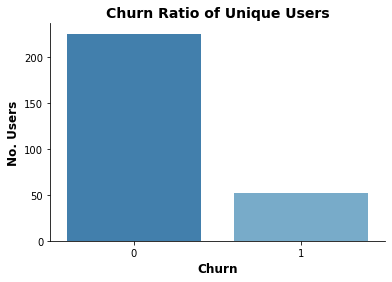

In [20]:
# plot churn ratio for unique users
user_churn = churn_df.dropDuplicates(["userId", "churn"]).groupby(["churn"]).count().sort("churn").toPandas()
ax = sns.barplot(x='churn', y='count', data=user_churn, palette='tab20c')

plt.title('Churn Ratio of Unique Users', size=14, fontweight = 'bold')
plt.xlabel('Churn', fontsize=12, weight='bold')
plt.ylabel('No. Users', fontsize=12, weight='bold')
sns.despine(ax=ax);

plt.savefig('plots/churn_ratio_unique_users.png')


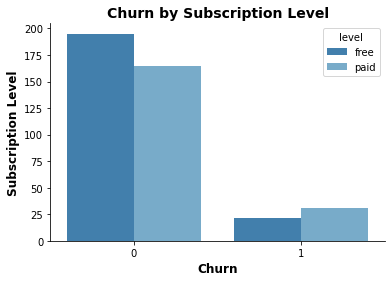

In [21]:
# plot churn ratio for paid and free subscribers 
level_churn = churn_df.dropDuplicates(["userId", 'level', "churn"]).groupby(["churn", 'level']).count().sort("churn").toPandas()
ax = sns.barplot(x="churn", y="count", hue='level', data=level_churn, palette='tab20c')

plt.title('Churn by Subscription Level', size=14, fontweight = 'bold')
plt.xlabel('Churn', fontsize=12, weight='bold')
plt.ylabel('Subscription Level', fontsize=12, weight='bold')
sns.despine(ax=ax);

plt.savefig('plots/churn_by_subscription_level')


## User Engagement & Page Events


In [22]:
# create a view for page events
df.createOrReplaceTempView("df_page")

# page events: users with userId & sessionId
spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_page
    EXCEPT
    SELECT DISTINCT page
    FROM df_page
    WHERE userId == ""
    '''
).show()


+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



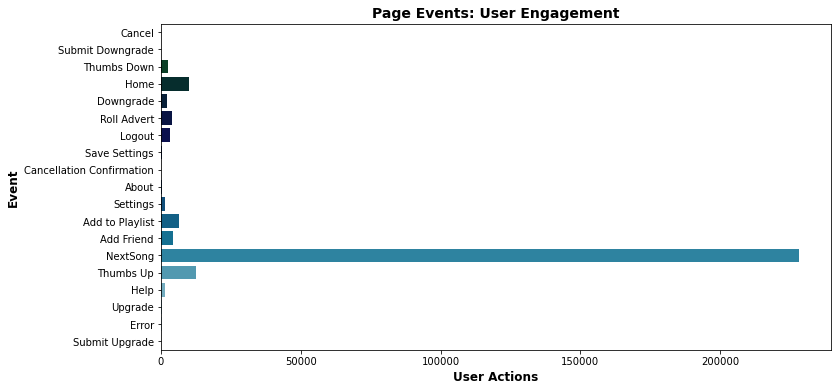

In [23]:
# plot page events
page_events = df.groupby("page").count().alias("count").toPandas()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x="count", y="page", data=page_events, palette='ocean')
ax.set_title("Page Events: User Engagement", fontsize=14, weight='bold')
ax.set_ylabel("Event", fontsize=12, weight='bold')
ax.set_xlabel("User Actions", fontsize=12, weight='bold')

plt.savefig('plots/page_events_user_engagement.png')


In [24]:
# create table for page events
page_events = df.groupBy(['userId']).pivot('page').count().fillna(0)
page_events = page_events.toPandas()
page_events = page_events.rename(columns={"Cancellation Confirmation": "churn"})
page_events.head()


,userId,About,Add Friend,Add to Playlist,Cancel,churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,100010,1,4,7,0,0,0,0,2,11,5,275,52,0,0,0,0,5,17,2
1,200002,3,4,8,0,0,5,0,2,20,5,387,7,0,3,0,1,6,21,2
2,125,0,0,0,1,1,0,0,0,0,0,8,1,0,0,0,0,0,0,0
3,51,2,28,52,1,1,23,1,12,75,24,2111,0,1,12,0,0,21,100,0
4,124,7,74,118,0,0,41,6,23,176,59,4079,4,6,20,0,0,41,171,0


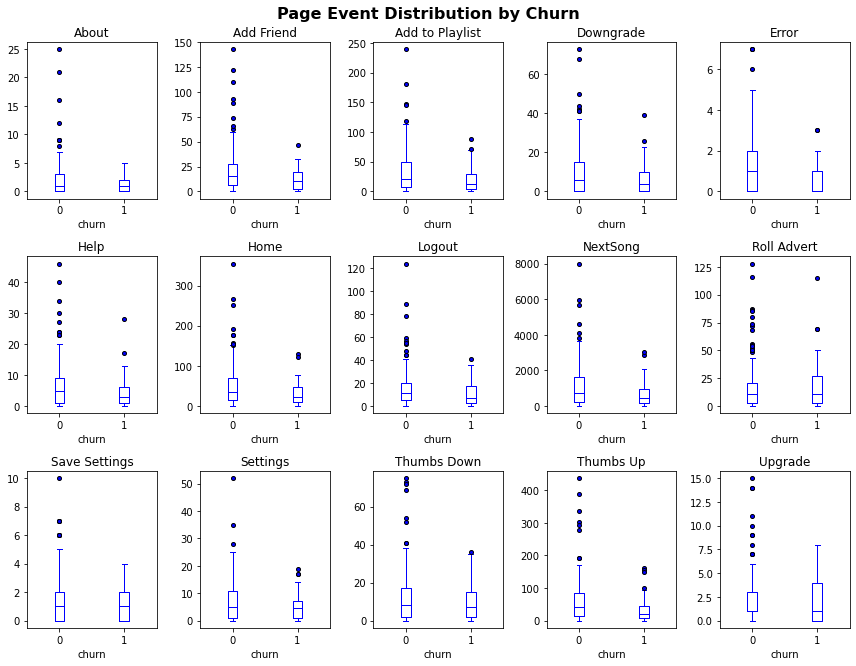

In [25]:
# plot variation in page events by churn
flierprops = dict(marker='o', markerfacecolor='blue', markersize=4,
                  linestyle='none')

fig = plt.figure(figsize=(12, 12))
page_features = ['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 
                 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Thumbs Down', 
                 'Thumbs Up', 'Upgrade']

for i, col in enumerate(page_features):
    ax = fig.add_subplot(4,5, i+1)
    page_events.boxplot(col, ax=ax, grid=False,  by='churn', flierprops=flierprops, color='blue');

fig.suptitle('Page Event Distribution by Churn', size=16, fontweight = 'bold')
plt.tight_layout()

plt.savefig('plots/page_event_distribution_by_churn.png')


/Users/andrewnachtigal/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 720x432 with 0 Axes>

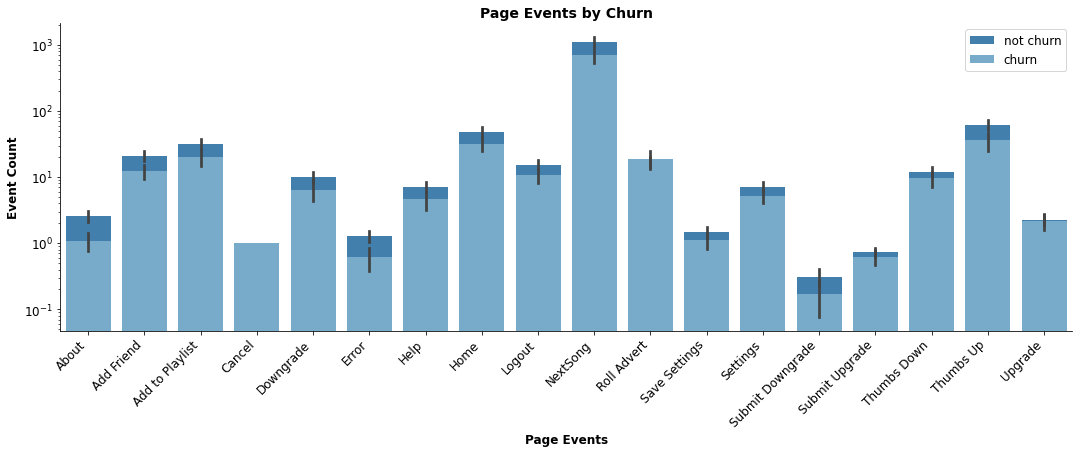

In [26]:
# plot page events by churn
page_events['churn'] = page_events['churn'].replace({1: "churn", 0: "not churn"})

page_events_melt = pd.melt(
    page_events, id_vars=['userId', 'churn'], 
    value_vars = list(page_events.columns[1:].drop('churn')),
    var_name='page', 
    value_name='visit_count'
).reset_index()

fig = plt.figure(figsize=(10, 6))
sns.factorplot(x="page", y="visit_count", hue="churn", data=page_events_melt, dodge=False,
               kind="bar", aspect=3, legend=False, log=True, palette='tab20c');
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.title("Page Events by Churn", size=14, fontweight='bold')
plt.xlabel("Page Events", fontsize=12, weight='bold')
plt.ylabel("Event Count", fontsize=12, weight='bold')
plt.legend(loc='best', fontsize=12);

plt.savefig('plots/page_events_by_churn.png')


## missing

In [27]:
# Delete columns with empty userid
sparkify_events = sparkify_events.filter(sparkify_events.userId != "")


## churn

In [28]:
# Flag definition for churn (Cancellation Confirmation)
churn_flag = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
sparkify_events = sparkify_events.withColumn("churn", churn_flag("page"))

# Apply churn flag to dataset
window_val = Window.partitionBy("userId")
sparkify_events = sparkify_events.withColumn("churn", Fsum("churn").over(window_val))


In [29]:
# churn
sparkify_events["userId", "churn"].dropDuplicates().groupby("churn").count().show()


+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [30]:
#sparkify_events
sparkify_events.show(n=1, truncate=False, vertical=True)


-RECORD 0------------------------------------------------------------------------------------------
 artist        | OneRepublic                                                                       
 auth          | Logged In                                                                         
 firstName     | Bryanna                                                                           
 gender        | F                                                                                 
 itemInSession | 0                                                                                 
 lastName      | Stone                                                                             
 length        | 224.67873                                                                         
 level         | paid                                                                              
 location      | Los Angeles-Long Beach-Anaheim, CA                                                


 # Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Features Used In Model
* Listened songs
* Average played songs per session
* Songs added to playlist
* Total different artists listened
* Average played time per session
* Sessions of the user
* Time passed since registration
* Friends number
* Thumbs up
* Thumbs down
* Help requests
* Errors
* Downgrade
* Gender
* Free or paid user
* Churn
* Roll Advertisements  


## Model Refinement

Initially, fewer features were used in modeling. Roll Adverts were included as an engineered feature after initial dataset features were used.

### feature: downgrade

In [31]:
# downgrade
# Flag definition for churn (Downgrade)
churn_downgrade = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
sparkify_events = sparkify_events.withColumn("downgrade", churn_downgrade("page"))

# Apply churn flag to dataset
windowval_val = Window.partitionBy("userId")
sparkify_events = sparkify_events.withColumn("downgrade", Fsum("downgrade").over(windowval_val))


In [32]:
# page events
data = sparkify_events.groupby("page").count().alias("count").toPandas()


### feature: roll advert

In [33]:
# Advertisements
# Flag definition for churn (advert)
churn_advert = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())
sparkify_events = sparkify_events.withColumn("roll_advert", churn_advert("page"))

# Apply churn flag to dataset
windowval_val = Window.partitionBy("userId")
sparkify_events = sparkify_events.withColumn("roll_advert", Fsum("roll_advert").over(windowval_val))


In [34]:
## Extract Features

# songs played
feat_listened_songs = sparkify_events.select('userID', 'page').where(sparkify_events.page == 'NextSong').groupBy('userID').\
                 count().withColumnRenamed('count', 'songs')

# Average played songs per session
feat_avg_songs_session = sparkify_events.where(sparkify_events.song.isNotNull()).groupby(['userId', 'sessionId']).count().\
                       groupby(['userId']).agg({'count': 'avg'}).withColumnRenamed('avg(count)', 'avg_songs_session')

# Songs added to playlist
feat_add_playlist = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Add to Playlist').\
                  groupBy('userId').count().withColumnRenamed('count', 'add_playlist')


# unique artists per user
feat_dif_artists = sparkify_events.select("userId", "artist").dropDuplicates().groupby("userId").count().\
                 withColumnRenamed('count', 'dif_artists')

# Average played time per session
played_max = sparkify_events.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'max')
played_min = sparkify_events.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'min')
played_session = played_min.join(played_max,['userId', 'sessionId'])
played_session = played_session.select('userId', 'sessionId', ((played_session.max-played_session.min)/(1000*60)).\
                 alias('played_session'))
                                                                                   
# Average session length
feat_played_time_session = played_session.groupBy('userId').agg(avg('played_session').alias('played_time_session'))     
feat_played_time_session = feat_played_time_session.na.fill(0)

# Number of Sessions per user
feat_sessions_user = sparkify_events.select("userId", "sessionId").dropDuplicates().groupby("userId").count().\
                   withColumnRenamed('count', 'sessions_user')

# User Tenure
latest_time = sparkify_events.groupby("userId").max("ts").sort("userId")
sign_up_moment = sparkify_events.select("userId", "registration").dropDuplicates().sort("userId")
feat_time_since_registration = sign_up_moment.join(latest_time, sign_up_moment.userId == latest_time.userId).\
                             select(sign_up_moment["userId"], ((latest_time["max(ts)"]-sign_up_moment["registration"])/(1000*60)).\
                             alias("registration_min"))

# Friends number
feat_friends = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Add Friend').groupBy('userId').\
            count().withColumnRenamed('count', 'friend').sort('userId')

# Thumbs up
feat_thumbs_up = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Thumbs Up').groupBy('userId').\
            count().withColumnRenamed('count', 'thumbs_up')

# Thumbs down
feat_thumbs_down = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Thumbs Down').groupBy('userId').\
            count().withColumnRenamed('count', 'thumbs_down')

# Help requests
feat_help = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Help').groupBy('userId').\
            count().withColumnRenamed('count', 'help')

# Errors
feat_errors = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Error').groupBy('userId').\
            count().withColumnRenamed('count', 'errors')

# Downgrade
feat_downgrade = sparkify_events["userId", "downgrade"].dropDuplicates()

# Gender
feat_gender = sparkify_events.groupby('userId').agg(first(when(sparkify_events.gender == "F", 1).otherwise(0)).alias('gender'))

# Free or paid user
feat_level = sparkify_events.groupby('userId').agg(last(when(sparkify_events.level == 'paid', 1).otherwise(0)).\
           alias('level'))

# Churn
feat_churn = sparkify_events.select('userId', 'churn').dropDuplicates()

# Roll Advert
feat_roll_advert = sparkify_events["userId", "roll_advert"].dropDuplicates()



In [70]:
# Join Features

def features(df):
    '''
    INPUT:
    df - dataframe with the data
    
    OUTPUT:
    feat_data - dataframe with the selected features
    
    '''
    
    start = datetime.datetime.now()
    
    feat_listened_songs = df.select('userID', 'page').where(df.page == 'NextSong').groupBy('userID').\
                 count().withColumnRenamed('count', 'songs')

    feat_avg_songs_session = df.where(df.song.isNotNull()).groupby(['userId', 'sessionId']).count().\
                           groupby(['userId']).agg({'count': 'avg'}).withColumnRenamed('avg(count)', 'avg_songs_session')

    feat_add_playlist = df.select('userId', 'page').where(df.page == 'Add to Playlist').\
                      groupBy('userId').count().withColumnRenamed('count', 'add_playlist')

    feat_dif_artists = df.select("userId", "artist").dropDuplicates().groupby("userId").count().\
                     withColumnRenamed('count', 'dif_artists')

    played_max = df.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'max')
    played_min = df.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'min')
    played_session = played_min.join(played_max,['userId', 'sessionId'])
    played_session = played_session.select('userId', 'sessionId', ((played_session.max-played_session.min)/(1000*60)).\
                     alias('played_session'))
    
    feat_played_time_session = played_session.groupBy('userId').agg(avg('played_session').alias('played_time_session'))
    
    feat_played_time_session = feat_played_time_session.na.fill(0)
    
    feat_sessions_user = df.select("userId", "sessionId").dropDuplicates().groupby("userId").count().\
                       withColumnRenamed('count', 'sessions_user')
    
    latest_time = df.groupby("userId").max("ts").sort("userId")
    
    sign_up_moment = df.select("userId", "registration").dropDuplicates().sort("userId")
    
    feat_time_since_registration = sign_up_moment.join(latest_time, sign_up_moment.userId == latest_time.userId).\
                                 select(sign_up_moment["userId"], ((latest_time["max(ts)"]-sign_up_moment["registration"])/(1000*60)).\
                                 alias("registration_min"))
    
    feat_friends = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').\
                count().withColumnRenamed('count', 'friend').sort('userId')
    
    feat_thumbs_up = df.select('userId', 'page').where(df.page == 'Thumbs Up').groupBy('userId').\
                count().withColumnRenamed('count', 'thumbs_up')

    feat_thumbs_down = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').\
                count().withColumnRenamed('count', 'thumbs_down')
    
    feat_help = df.select('userId', 'page').where(df.page == 'Help').groupBy('userId').\
                count().withColumnRenamed('count', 'help')
    
    feat_errors = df.select('userId', 'page').where(df.page == 'Error').groupBy('userId').\
                count().withColumnRenamed('count', 'errors')
    
    feat_downgrade = df["userId", "downgrade"].dropDuplicates()
    
    feat_gender = df.groupby('userId').agg(first(when(df.gender == "F", 1).otherwise(0)).alias('gender'))
    
    feat_level = df.groupby('userId').agg(last(when(df.level == 'paid', 1).otherwise(0)).\
               alias('level'))
    
    feat_churn = df.select('userId', 'churn').dropDuplicates()
    
    feat_roll_advert = df.select('userId', 'roll_advert').dropDuplicates()
    
    
    ############################### ############################### ###############################

    # join features
    feat_data = feat_listened_songs.join(feat_avg_songs_session,'userID','outer').\
                                join(feat_add_playlist,'userID','outer').\
                                join(feat_dif_artists,'userID','outer').\
                                join(feat_played_time_session,'userID','outer').\
                                join(feat_sessions_user,'userID','outer').\
                                join(feat_time_since_registration,'userID','outer').\
                                join(feat_friends,'userID','outer').\
                                join(feat_thumbs_up,'userID','outer').\
                                join(feat_thumbs_down,'userID','outer').\
                                join(feat_help,'userID','outer').\
                                join(feat_errors,'userID','outer').\
                                join(feat_downgrade,'userID','outer').\
                                join(feat_gender,'userID','outer').\
                                join(feat_level,'userID','outer').\
                                join(feat_churn,'userID','outer').\
                                join(feat_roll_advert,'userID','outer').\
                                drop('userID').\
                                fillna(0)
    
    return feat_data


In [36]:
df_features = features(sparkify_events)


In [37]:
df_features

DataFrame[songs: bigint, avg_songs_session: double, add_playlist: bigint, dif_artists: bigint, played_time_session: double, sessions_user: bigint, registration_min: double, friend: bigint, thumbs_up: bigint, thumbs_down: bigint, help: bigint, errors: bigint, downgrade: bigint, gender: int, level: int, churn: bigint, roll_advert: bigint]

## Feature Multicollinearity

In [50]:
# Convert to pandas
df_features_pd = df_features.toPandas()


In [51]:
df_features_pd.columns
df_features_pd.head(5)


Index(['songs', 'avg_songs_session', 'add_playlist', 'dif_artists',
       'played_time_session', 'sessions_user', 'registration_min', 'friend',
       'thumbs_up', 'thumbs_down', 'help', 'errors', 'downgrade', 'gender',
       'level', 'churn', 'roll_advert'],
      dtype='object')

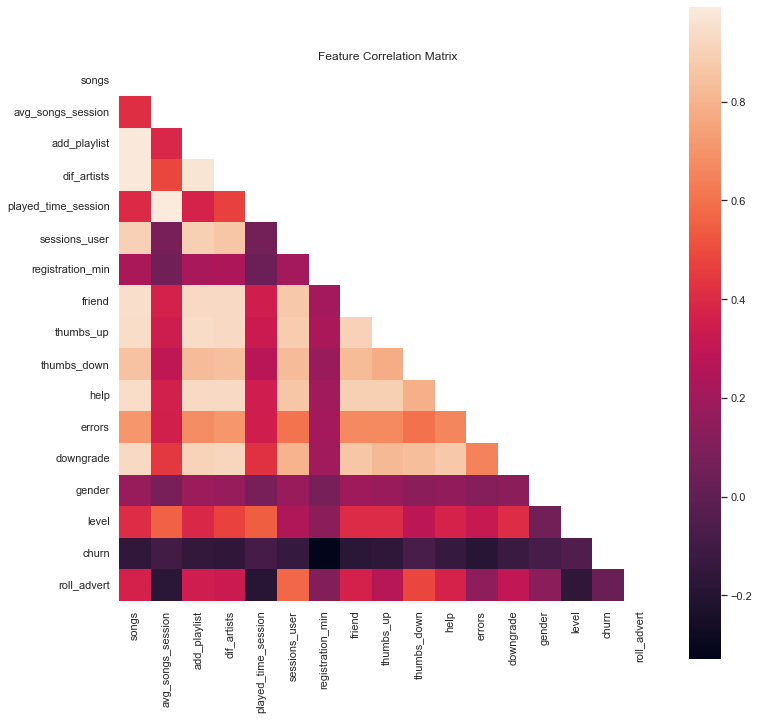

In [58]:
# %%time
# correlation plot for numerical variables
corr = df_features.toPandas().corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.set(rc={'figure.figsize':(12, 12)})
with sns.axes_style("white"):
    sns.heatmap(corr, annot=False, square=True, mask=mask)
    plt.title("Feature Correlation Matrix")

plt.savefig('plots/feature_correlation_matrix.png')


**Correlation Analysis Comments**

Correlation between features is analyzed using a heat map. Friend, thumbs_up, thumbs_down, help, errors, and downgrade exhibit higher corrlation. User tenure (registration_min), churn, and gender have lower correlation.



## Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## Convert feature data for model

In [39]:
# Data conversion to integer and float
def convert_int_float(df, int_features, float_features):
    '''
    INPUT:
    df - dataframe with the data
    int_features - list with the variables to be converted to integer
    float_features - list with the variables to be converted to float
    OUTPUT:
    df_features_i_f - dataframe with the converted features
    
    Function that convert each column to the desired integer or float format
    '''

    df_features_i_f = df

    # Integer
    for col in int_features:
        df_features_i_f = df_features_i_f.withColumn(col, df_features_i_f[col].cast(IntegerType()))

    # Float
    for col in float_features:
        df_features_i_f = df_features_i_f.withColumn(col, df_features_i_f[col].cast(FloatType()))
        
    return df_features_i_f


In [40]:
def feature_scale(df):
    '''
    INPUT:
    df - dataframe with the data
    OUTPUT:
    df_features_scaled - dataframe with the selected features scaled
    
    Function that scales the features to be used in the Machine Learning algorithm
    '''
    
    start = datetime.datetime.now()
        
    features_mod = ["songs", "avg_songs_session",  "add_playlist", "dif_artists", "played_time_session",\
                    "sessions_user", "registration_min", "friend", "thumbs_up", "thumbs_down", "help",\
                    "errors", "downgrade", "gender", "level", "roll_advert"]

    print("Executing VectorAssembler...")
    vec_assembler = VectorAssembler(inputCols=features_mod, outputCol="Features")
    df_features_i_f_assembled = vec_assembler.transform(df)

    print("Executing StandardScaler...")
    scaled = StandardScaler(inputCol='Features', outputCol='scaled_features', withMean=True, withStd=True)

    print("Fit...")
    scaled_fit = scaled.fit(df_features_i_f_assembled)
    print("Transform...")
    df_features_i_f_scaled = scaled_fit.transform(df_features_i_f_assembled)

    print("Joining features...")
    df_features_scaled = df_features_i_f_scaled.select(df_features_i_f_assembled.churn.alias('label'),\
                         df_features_i_f_scaled.scaled_features.alias('features'))
    
    print("Feature scale finished")
    print("\n")
    print ("The process took",datetime.datetime.now()-start,"seconds")
    
    return df_features_scaled



In [41]:
# Specify the colums to be converted
feat_int = ["songs", "add_playlist", "dif_artists", "sessions_user", "friend", "thumbs_up", "thumbs_down", "help",
          "errors", "downgrade", "gender", "level", "churn", "roll_advert"]

feat_float = ["avg_songs_session","played_time_session","registration_min"]

df_features_i_f = convert_int_float(df_features, feat_int, feat_float)

df_features_i_f.printSchema()


root
 |-- songs: integer (nullable = true)
 |-- avg_songs_session: float (nullable = false)
 |-- add_playlist: integer (nullable = true)
 |-- dif_artists: integer (nullable = true)
 |-- played_time_session: float (nullable = false)
 |-- sessions_user: integer (nullable = true)
 |-- registration_min: float (nullable = false)
 |-- friend: integer (nullable = true)
 |-- thumbs_up: integer (nullable = true)
 |-- thumbs_down: integer (nullable = true)
 |-- help: integer (nullable = true)
 |-- errors: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- roll_advert: integer (nullable = true)



In [42]:
df_features_scaled = feature_scale(df_features_i_f)


Executing VectorAssembler...
Executing StandardScaler...
Fit...
22/12/04 13:22:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Transform...
Joining features...
Feature scale finished


The process took 0:00:21.660119 seconds


In [43]:
df_features_scaled.show(10)


+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-0.3084393038631...|
|    0|[1.50972477851168...|
|    1|[-0.7971444330231...|
|    0|[-0.7410338441196...|
|    1|[-0.8713552118956...|
|    0|[-0.0649917487816...|
|    1|[-0.7781392335558...|
|    1|[-0.8939804493567...|
|    1|[-0.5346916784742...|
|    0|[-0.2188433635171...|
+-----+--------------------+
only showing top 10 rows



In [44]:
# Split data in train and test datasets
train, test = df_features_scaled.randomSplit([0.8, 0.2], seed=42)


In [45]:
def train_predict_ML_model(train, test, ML_model):
    '''
    INPUT:
    train - train dataset, test - test dataset
    
    OUTPUT:
    accuracy - accuracy score
    f1score - f1 score
    elapsed_time - time spent in training the model
    
    '''
    
    start = datetime.datetime.now()
    
    if ML_model == "Logistic Regression":
        print("Logistic Regression model Initialization")
        model = LogisticRegression(labelCol = "label", featuresCol = "features", maxIter = 10)
        print("GridBuilder")
        paramGrid = ParamGridBuilder().addGrid(model.elasticNetParam, [0.0, 0.2, 0.6, 1.0]).\
                                       addGrid(model.regParam, [0.02, 0.06, 0.1]).\
                                       build()
    
    elif ML_model == "Random Forest":
    
        print("Random Forest model Initialization")
        model = RandomForestClassifier(labelCol = "label", featuresCol = "features")
        print("GridBuilder")
        paramGrid = ParamGridBuilder().addGrid(model.maxDepth, [5, 10]).\
                                       addGrid(model.numTrees, [10, 20]).\
                                       addGrid(model.impurity, ['entropy', 'gini']).\
                                       build()
        
    elif ML_model == "Decision Tree":
        print("Decision Tree model Initialization")
        model = DecisionTreeClassifier(labelCol = "label", featuresCol = "features", seed = 42)
        print("GridBuilder")
        paramGrid = ParamGridBuilder().addGrid(model.impurity, ['entropy', 'gini']).\
                                       addGrid(model.maxDepth, [2, 3, 5, 8, 13, 21, 30]).\
                                       build()

    elif ML_model == "Gradient Boosted Trees":
        print("Gradient Boosted Trees model Initialization")
        model = GBTClassifier(labelCol = "label", featuresCol = "features", maxIter = 10, seed = 42)
        print("GridBuilder")
        paramGrid = ParamGridBuilder().addGrid(model.maxDepth, [3, 5, 7]).\
                                       addGrid(model.maxIter, [6, 12]).\
                                       build()
        
    elif ML_model == "LinearSVC":
        print("LinearSVC model Initialization")
        model = LinearSVC(labelCol = "label", featuresCol = "features")
        print("GridBuilder")
        paramGrid = ParamGridBuilder().addGrid(model.maxIter, [6, 12]).\
                                       addGrid(model.regParam, [0.02, 0.06, 0.1]).\
                                       build()

    else:
        BOLD = '\033[1m'
        print(BOLD + "The specified model is not yet implemented. Select another model from the list" + BOLD)
        return
    
    
    print("F1 score evaluation")
    f1_eval = MulticlassClassificationEvaluator(metricName = 'f1')
    
    print("Cross Validation")
    crossval = CrossValidator(estimator = model, estimatorParamMaps = paramGrid, evaluator = f1_eval, numFolds = 3)
    
    print("Fit Model")
    model_fit = crossval.fit(train)
    
    print("Transform")
    results = model_fit.transform(test)
    
    print("Evaluation of the model")
    evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
    
    # Results
    accuracy = evaluator.evaluate(results, {evaluator.metricName: "accuracy"})
    f1score = evaluator.evaluate(results, {evaluator.metricName: "f1"})
    end = datetime.datetime.now()
    elapsed_time = (end - start)#.total_seconds()
    
    print ("The process took",end - start,"minutes")
    print("\n")
   
    return ML_model, accuracy, f1score, elapsed_time, model_fit




In [46]:
def train_model_execution(train, test):
    '''
    INPUT:
    train - train dataset, test - test dataset
    
    OUTPUT:
    model_name - model name used
    accuracy - accuracy score
    f1score - f1 score
    elapsed_time - time spent in training the model
    
    '''
    
    # Define variables used to save the results obtained
    model_name = []
    accuracy = []
    f1score = []
    elapsed_time = []
    model_fit = []
    
    model_nam, acc, f1s, elapsed_t, model_f = train_predict_ML_model(train, test, "Logistic Regression")
    model_name.append(model_nam)
    accuracy.append(acc)
    f1score.append(f1s)
    elapsed_time.append(elapsed_t)
    model_fit.append(model_f)
    
    model_nam, acc, f1s, elapsed_t, model_f = train_predict_ML_model(train, test, "Random Forest")
    model_name.append(model_nam)
    accuracy.append(acc)
    f1score.append(f1s)
    elapsed_time.append(elapsed_t)
    model_fit.append(model_f)
    
    model_nam, acc, f1s, elapsed_t, model_f = train_predict_ML_model(train, test, "Decision Tree")
    model_name.append(model_nam)
    accuracy.append(acc)
    f1score.append(f1s)
    elapsed_time.append(elapsed_t)
    model_fit.append(model_f)
    
    model_nam, acc, f1s, elapsed_t, model_f = train_predict_ML_model(train, test, "Gradient Boosted Trees")
    model_name.append(model_nam)
    accuracy.append(acc)
    f1score.append(f1s)
    elapsed_time.append(elapsed_t)
    model_fit.append(model_f)
    
    model_nam, acc, f1s, elapsed_t, model_f = train_predict_ML_model(train, test, "LinearSVC")
    model_name.append(model_nam)
    accuracy.append(acc)
    f1score.append(f1s)
    elapsed_time.append(elapsed_t)
    model_fit.append(model_f)
    
    return model_name, accuracy, f1score, elapsed_time, model_fit



In [47]:
# Execute the function that will train all the models
model_name, accuracy, f1score, elapsed_time, model_fit = train_model_execution(train, test)


Logistic Regression model Initialization
GridBuilder
F1 score evaluation
Cross Validation
Fit Model


22/12/04 13:24:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/04 13:24:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Transform
Evaluation of the model


The process took 0:20:00.105321 minutes


Random Forest model Initialization
GridBuilder
F1 score evaluation
Cross Validation
Fit Model


Transform
Evaluation of the model


The process took 0:16:11.130489 minutes


Decision Tree model Initialization
GridBuilder
F1 score evaluation
Cross Validation
Fit Model


Transform
Evaluation of the model


The process took 0:18:24.188392 minutes


Gradient Boosted Trees model Initialization
GridBuilder
F1 score evaluation
Cross Validation
Fit Model


Transform
Evaluation of the model


The process took 0:29:02.641496 minutes


LinearSVC model Initialization
GridBuilder
F1 score evaluation
Cross Validation
Fit Model


Transform
Evaluation of the model


The process took 0:17:43.810483 minutes




In [73]:
def results(model_name, accuracy, f1score, elapsed_time):
    '''
    INPUT:
    train - train dataset
    test - test dataset
    OUTPUT:
    model_name - model name used
    accuracy - accuracy score
    f1score - f1 score
    elapsed_time - time spent in training the model
    
    Function that plots the results obtained in the training of the Machine Learning models
    '''
    
    # Dataframe with the results obtained for each model
    results = pd.DataFrame(columns = ['Model name', 'Accuracy', 'f1score','Training time (h:m:s)'])
    results['Model name'] = model_name
    results['Accuracy'] = accuracy
    results['f1score'] = f1score
    results['Training time (h:m:s)'] = elapsed_time
    
    print(results.to_string(index=False))
    
    # Plot Accuracy
    plt.figure(figsize = (12, 6))
    sns.set(style = "whitegrid")
    ax = sns.barplot(x = 'Accuracy', y = 'Model name', orient = "h", data = results, palette='ocean')
    ax.set_title("Accuracy", fontsize = 16,weight='bold')
    
    ax.set_ylabel("Model", fontsize=12, weight='bold')
    ax.set_xlabel("", fontsize=12, weight='bold')
    
    plt.savefig('plots/model_accuracy.png')

    
    # Plot F1score
    plt.figure(figsize = (12, 6))
    sns.set(style = "whitegrid")
    ax = sns.barplot(x = 'f1score', y = 'Model name', orient = "h", data = results, palette='ocean')
    ax.set_title("F1 Score", fontsize = 14, weight='bold')
    
    ax.set_ylabel("Model", fontsize=12, weight='bold')
    ax.set_xlabel("", fontsize=12, weight='bold')
    
    plt.savefig('plots/f1_score.png')


            Model name  Accuracy  f1score  Training time (h:m:s)
   Logistic Regression  0.914286 0.902108 0 days 00:20:00.105321
         Random Forest  0.742857 0.733348 0 days 00:16:11.130489
         Decision Tree  0.800000 0.805938 0 days 00:18:24.188392
Gradient Boosted Trees  0.800000 0.805938 0 days 00:29:02.641496
             LinearSVC  0.828571 0.750893 0 days 00:17:43.810483


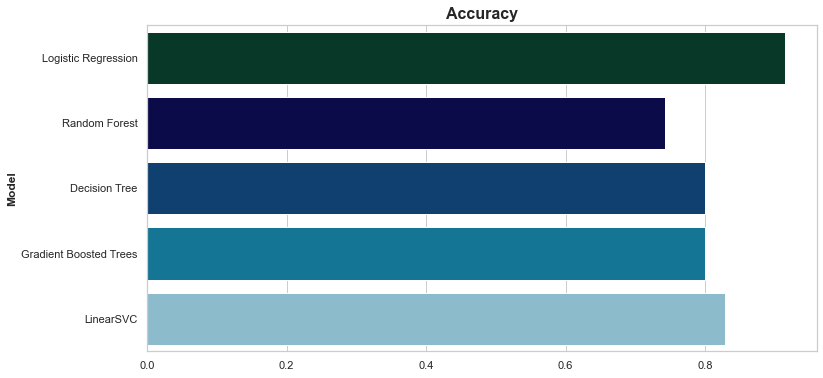

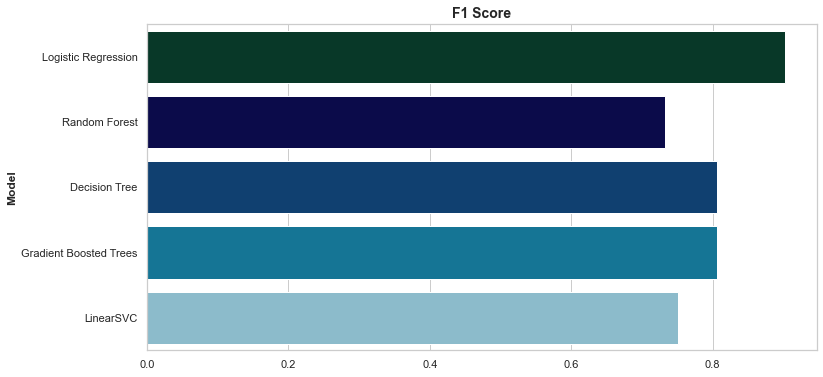

In [74]:
results(model_name, accuracy, f1score, np.array(elapsed_time))


## Model Evaluation and Validation

**Parameters Evaluation**
Using Accuracy and F1 Score as metrics, a logistic regression model performed better than four other models, exceeding 0.9.

**Model Validation**  
Cross-validation is used to validate the robustness of the model solution. cross-validation to find the best parameters.  
  
  
**Model comparison and results** 
The results of four different models are shown below.



### Best Model Fit
* Logistic Regression

In [62]:
# select model
model_fit[0].bestModel


LogisticRegressionModel: uid=LogisticRegression_5f3af877ee9f, numClasses=2, numFeatures=16

In [63]:
# select model
model_fit[0].bestModel.regParam


Param(parent='LogisticRegression_5f3af877ee9f', name='regParam', doc='regularization parameter (>= 0).')

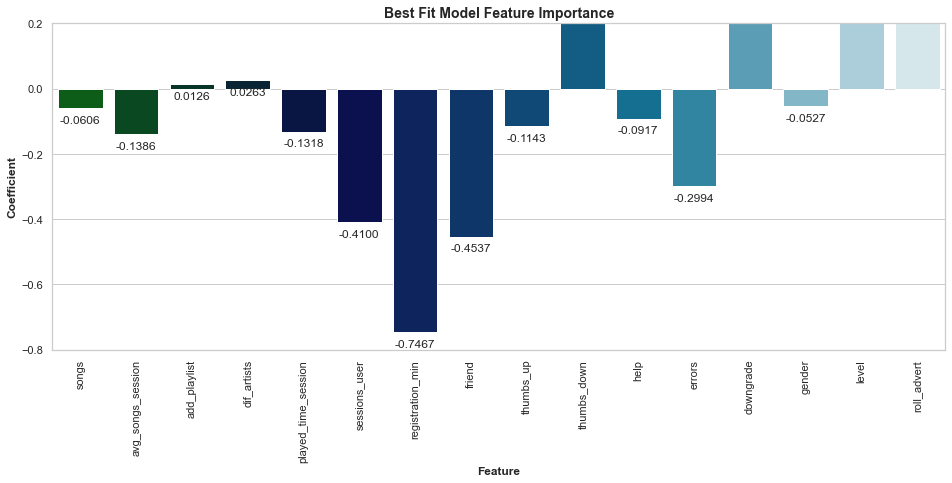

In [67]:
# plot best model fit
model_best = model_fit[0].bestModel

coeff = []
for i in model_best.coefficients:
    coeff.append(i)

features = ["songs", "avg_songs_session", "add_playlist", "dif_artists", "played_time_session", "sessions_user",
            "registration_min", "friend", "thumbs_up", "thumbs_down", "help", "errors", "downgrade", "gender",
            "level", "roll_advert"]

LR_coeff = pd.DataFrame()
LR_coeff['features'] = features
LR_coeff['coeff'] = coeff

# Plot coefficients
plt.figure(figsize = (16, 6))
sns.set(style = "whitegrid")
ax = sns.barplot(x = 'features', y = 'coeff', data = LR_coeff, palette='ocean')
ax.set_title("Best Fit Model Feature Importance", fontsize = 14, weight="bold")
ax.set_xlabel("Feature", fontsize = 12, weight = 'bold')
ax.set_ylabel("Coefficient", fontsize = 12, weight = 'bold')
ax.set_xticklabels(labels = LR_coeff['features'],rotation = 90)
ax.set_ylim(-0.8, 0.2)

for m in ax.patches:
        ax.annotate(format(m.get_height(), '.4f'), (m.get_x() + m.get_width() / 2., 
                           m.get_height()), ha = 'center', va = 'center', xytext = (0, -12), 
                           textcoords = 'offset points')

plt.savefig('plots/model_feature_importance.png')


## Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

# Conclusion

The project is completely contained in this Notebook and all the steps were executed using the PySpark library for using Spark with Python.  


**Project Reflection**. 


The total amount of features used in the churn prediction model was 15, 5 different Machine Learning models were trained using crossvalidation and for finding the best parameters Grid Search was the chosen option.   


The model with the best result is Logistic Regresion with an accuracy of 0.885 and a f1 score of 0.861. The features that have more impact are registration_min, errors, friend, played_time_session, avg_songs_session and thumbs_down. From them, the more negative the value of these features are, most likely the user will stay in the service and will not churn.  


**Improvements**

Model improve would include a larger dataset where the models have more data and the use of more parameters in Grid Search to tune the models. These measure would allow to increment the accuracy of the predictions and be more effective therefore in managing the churn problem.
